In [1]:
# Import necessary libraries

import time
import random
import numpy as np
import copy
import json
from collections import Counter
from typing import Dict, Any, List, Tuple

import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, ProgressBarCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy as PPOMlp
from baselines import logger

from stable_baselines3 import DQN

# Import Yawning Titan specific modules
from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.core.action_loops import ActionLoop
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.game_modes.game_mode import GameMode
from yawning_titan.networks.node import Node
from yawning_titan.networks.network import Network
from yawning_titan.envs.generic.core import reward_functions
from yawning_titan.envs.generic.helpers.eval_printout import EvalPrintout
from yawning_titan.envs.generic.helpers.graph2plot import CustomEnvGraph

# Import Reward Machine related modules
from reward_machines.reward_machine import RewardMachine
from reward_machines.rm_environment import RewardMachineEnv, RewardMachineWrapper
from reward_machines.reward_functions import ConstantRewardFunction
from reward_machines.reward_machine_utils import evaluate_dnf

In [2]:
# Load the game mode from a YAML file
game_mode = GameMode()
game_mode = game_mode.create_from_yaml(yaml='game_mode_balanced RM.yaml', legacy=False, infer_legacy=True)
print(game_mode.game_rules.max_steps.value)

# Create a network representation
network = Network()

# Define network nodes and their positions

# External layer
router_1 = Node("Boundary router packet filter")
router_1.node_position = [0, 600]
network.add_node(router_1)

switch_1 = Node("External switch")
switch_1.node_position = [0, 500]
network.add_node(switch_1)

network_ids_1 = Node("Network IDS (DMZ)")
network_ids_1.node_position = [-200, 500]
network.add_node(network_ids_1)

dns_server_external = Node("DNS server esterno")
dns_server_external.node_position = [200, 500]
network.add_node(dns_server_external)

# DMZ layer
server_1 = Node("Main Firewall/VPN server/NAT")
server_1.node_position = [-100, 400]
network.add_node(server_1)

server_2 = Node("External Web Server/Host IDS")
server_2.node_position = [100, 400]
network.add_node(server_2)

switch_2 = Node("Internal Switch (DMZ)")
switch_2.node_position = [0, 300]
network.add_node(switch_2)

network_ids_2 = Node("Network IDS (DMZ Internal)")
network_ids_2.node_position = [-200, 300]
network.add_node(network_ids_2)

# Internal layer
internal_firewall = Node("Internal Firewall")
internal_firewall.node_position = [0, 200]
network.add_node(internal_firewall)

server_3 = Node("Database Server")
server_3.node_position = [200, 200]
network.add_node(server_3)

email_server = Node("Email Server/Host IDS")
email_server.node_position = [-200, 200]
network.add_node(email_server)

dns_server_internal = Node("DNS server interno")
dns_server_internal.node_position = [400, 200]
network.add_node(dns_server_internal)

web_proxy = Node("Web proxy server")
web_proxy.node_position = [-400, 200]
network.add_node(web_proxy)

switch_3 = Node("Internal Switch")
switch_3.node_position = [0, 100]
network.add_node(switch_3)

network_ids_3 = Node("Network IDS Internal")
network_ids_3.node_position = [-200, 100]
network.add_node(network_ids_3)

# Subnet layer
subnet1_router = Node("Router Subnet 1")
subnet1_router.node_position = [-300, 0]
network.add_node(subnet1_router)

subnet2_router = Node("Router Subnet 2")
subnet2_router.node_position = [-100, 0]
network.add_node(subnet2_router)

subnet3_router = Node("Router Subnet 3")
subnet3_router.node_position = [100, 0]
network.add_node(subnet3_router)

subnet4_router = Node("Router Subnet 4")
subnet4_router.node_position = [300, 0]
network.add_node(subnet4_router)

# Client/Server layer
client1_management = Node("Client1 Management")
client1_management.node_position = [-300, -100]
network.add_node(client1_management)

client1_hr = Node("Client1 HR")
client1_hr.node_position = [-100, -100]
network.add_node(client1_hr)

client1_it = Node("Client1 IT")
client1_it.node_position = [100, -100]
network.add_node(client1_it)

server_backup = Node("Server backup")
server_backup.node_position = [300, -100]
network.add_node(server_backup)

# Add edges to connect nodes
network.add_edge(router_1, switch_1)
network.add_edge(switch_1, server_1)
network.add_edge(switch_1, server_2)
network.add_edge(switch_1, network_ids_1)
network.add_edge(switch_1, dns_server_external)
network.add_edge(server_1, switch_2)
network.add_edge(switch_2, server_3)
network.add_edge(switch_2, internal_firewall)
network.add_edge(switch_2, email_server)
network.add_edge(switch_2, dns_server_internal)
network.add_edge(switch_2, web_proxy)
network.add_edge(switch_2, network_ids_2)
network.add_edge(internal_firewall, switch_3)
network.add_edge(switch_3, network_ids_3)
network.add_edge(switch_3, subnet1_router)
network.add_edge(switch_3, subnet2_router)
network.add_edge(switch_3, subnet3_router)
network.add_edge(switch_3, subnet4_router)
network.add_edge(subnet1_router, client1_management)
network.add_edge(subnet2_router, client1_hr)
network.add_edge(subnet3_router, client1_it)
network.add_edge(subnet4_router, server_backup)


# Set entry and high-value nodes
router_1.entry_node = True
server_3.high_value_node = True
server_backup.high_value_node = True


# Display the network details
network.show(verbose=True)

300
UUID                                  Name                           High Value Node    Entry Node      Vulnerability  Position (x,y)
------------------------------------  -----------------------------  -----------------  ------------  ---------------  ----------------
a5c67faf-cd24-43ce-9b9a-a3e6ceb53843  Boundary router packet filter  False              True                     0.01  0.00, 600.00
16146d9a-af66-4f5c-bf43-8f61895e26a9  External switch                False              False                    0.01  0.00, 500.00
3ce181db-f40e-43a7-a270-d97f7ee23ff3  Network IDS (DMZ)              False              False                    0.01  -200.00, 500.00
728c6751-59df-4b68-b0a2-ac1af8bf8c7f  DNS server esterno             False              False                    0.01  200.00, 500.00
59cb37c2-505a-4c87-8a52-75e72d97b907  Main Firewall/VPN server/NAT   False              False                    0.01  -100.00, 400.00
e085b336-a2c4-4ded-9016-f9f3edac4e21  External Web Server/

In [3]:
# Create NetworkInterface, RedInterface, and BlueInterface objects
network_interface = NetworkInterface(game_mode=game_mode, network=network)
red = RedInterface(network_interface)
blue = BlueInterface(network_interface)

In [4]:
class YawningTitanRMEnv(RewardMachineEnv):
    def __init__(self, env, rm_files):
        super().__init__(env, rm_files)

In [5]:
class YawningTitanTest:
    
    def __init__(self):
        pass

In [6]:
"""
A generic class that creates Open AI environments within YAWNING TITAN.

This class has several key inputs which determine aspects of the environment such
as how the red agent behaves, what the red team and blue team objectives are, the size
and topology of the network being defended and what data should be collected during the simulation.
"""

class GenericNetworkRMEnv(gym.Env):
    """Class to create a generic YAWNING TITAN gym environment."""

    def __init__(
        self,
        env,
        red_agent: RedInterface,
        blue_agent: BlueInterface,
        network_interface: NetworkInterface,
        rm_files,
        print_metrics: bool = False,
        show_metrics_every: int = 1,
        collect_additional_per_ts_data: bool = True,
        print_per_ts_data: bool = False,
    ):
        """
        Initialise the generic network environment.

        Args:
            env: The base environment
            red_agent: Object from the RedInterface class
            blue_agent: Object from the BlueInterface class
            network_interface: Object from the NetworkInterface class
            rm_files: List of reward machine files
            print_metrics: Whether or not to print metrics (boolean)
            show_metrics_every: Number of timesteps to show summary metrics (int)
            collect_additional_per_ts_data: Whether or not to collect additional per timestep data (boolean)
            print_per_ts_data: Whether or not to print collected per timestep data (boolean)
        """
        super(GenericNetworkRMEnv, self).__init__()
        self.env = env
        self.RED = red_agent
        self.BLUE = blue_agent
        self.blue_actions = blue_agent.get_number_of_actions()
        self.network_interface = network_interface
        self.rm_files = rm_files
        self.current_duration = 0
        self.game_stats_list = []
        self.num_games_since_avg = 0
        self.avg_every = show_metrics_every
        self.current_game_blue = {}
        self.current_game_stats = {}
        self.total_games = 0
        self.total_fails = 0
        self.made_safe_nodes = []
        self.current_reward = 0
        self.print_metrics = print_metrics
        self.print_notes = print_per_ts_data


        self.random_seed = self.network_interface.random_seed

        self.graph_plotter = None
        self.eval_printout = EvalPrintout(self.avg_every)

        self.action_space = spaces.Discrete(self.blue_actions)

        self.network_interface.get_observation_size()

        # sets up the observation space. This is a (n+2 by n) matrix. The first two columns show the state of all the
        # nodes. The remaining n columns show the connections between the nodes (effectively the adjacency matrix)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(self.network_interface.get_observation_size(),),
            dtype=np.float32,
        )

        # The gym environment can only properly deal with a 1d array so the observation is flattened

        self.collect_data = collect_additional_per_ts_data
        self.env_observation = self.network_interface.get_current_observation()
    
    def get_true_propositions(self):
        self.true_props = ""

        compromised = any(node.true_compromised_status for node in self.network_interface.current_graph.get_nodes())
        max_steps_reached = self.current_duration == self.network_interface.game_mode.game_rules.max_steps.value
        high_value_compromised = any(node.true_compromised_status for node in self.network_interface.current_graph.get_nodes() if node.high_value_node)

        if compromised:
            self.true_props += 'c'
        if max_steps_reached:
            self.true_props += 'm'
        if high_value_compromised:
            self.true_props += 'h'
            self.total_fails += 1

        return self.true_props
    
    def get_fail_rate(self):
        return self.total_fails / self.total_games if self.total_games > 0 else 0
    
    def get_events(self):
        return self.get_true_propositions()
    
    def execute_action(self, action: int) -> Tuple[np.array, bool, Dict[str, dict]]:
        """
        Executes the 'action' in the Yawning Titan environment.

        Args:
            action: The action to be executed by the Blue agent.

        Returns:
            A tuple containing:
            - The next observation (flattened numpy array)
            - A boolean indicating if the episode is done
            - Additional information (dictionary)
        """
        # Initialize variables
        done = False
        blue_action = ""
        blue_node = None

        # Store the initial state of the environment
        initial_state = self.network_interface.get_all_node_compromised_states()

        # Execute the Blue agent's action
        blue_action, blue_node = self.BLUE.perform_action(action)

        # Store the result of the Blue action
        if blue_action == "make_node_safe" or blue_action == "restore_node":
            self.made_safe_nodes.append(blue_node)

        # Determine the Red agent's actions and update the state
        if (
            self.network_interface.game_mode.game_rules.grace_period_length.value
            <= self.current_duration
        ):
            red_info = self.RED.perform_action()
        else:
            red_info = {
                0: {
                    "Action": "do_nothing",
                    "Attacking_Nodes": [],
                    "Target_Nodes": [],
                    "Successes": [True],
                }
            }

        # Update the state of the environment after the actions
        post_red_state = self.network_interface.get_all_node_compromised_states()

        # Update the observation
        self.env_observation = self.network_interface.get_current_observation().flatten()
        self.current_duration += 1

        # Check if the episode is done (e.g., maximum steps reached, all nodes compromised)
        if self.current_duration == self.network_interface.game_mode.game_rules.max_steps.value:
            done = True

        # Additional information to return
        info = {
            "blue_action": blue_action,
            "blue_node": blue_node,
            "red_info": red_info,
            "post_red_state": post_red_state,
        }

        return self.env_observation, done, info

    def step(self, action):
        self.execute_action(action)
        reward = 0 # all the reward comes from the RM
        done = False
        info = {}
        return self.env_observation, reward, done, info

    def reset(self) -> np.array:
        """
        Reset the environment to the default state.

        :todo: May need to add customization of cuda setting.

        :return: A new starting observation (numpy array).
        """
        
        if self.random_seed is not None:  # conditionally set random_seed
            set_random_seed(self.random_seed, True)
        self.network_interface.reset()
        self.RED.reset()
        self.current_duration = 0
        self.env_observation = self.network_interface.get_current_observation()
        self.current_game_blue = {}

        return self.env_observation

  
    def render(
        self,
        mode: str = "human",
        show_only_blue_view: bool = False,
        show_node_names: bool = False,
    ):
        """
        Render the environment using Matplotlib to create an animation.

        Args:
            mode: the mode of the rendering
            show_only_blue_view: If true shows only what the blue agent can see
            show_node_names: Show the names of the nodes
        """
        if self.graph_plotter is None:
            self.graph_plotter = CustomEnvGraph()

        # gets the networkx object

        # compromised nodes is a dictionary of all the compromised nodes with a 1 if the compromise is known or a 0 if
        # not
        # gets information about the current state from the network interface
        main_graph = self.network_interface.current_graph
        if show_only_blue_view:
            attacks = self.network_interface.detected_attacks
        else:
            attacks = self.network_interface.true_attacks
        reward = round(self.current_reward, 2)

        # sends the current information to a graph plotter to display the information visually
        self.graph_plotter.render(
            current_step=self.current_duration,
            g=main_graph,
            attacked_nodes=attacks,
            current_time_step_reward=reward,
            # self.network_interface.red_current_location,
            made_safe_nodes=self.made_safe_nodes,
            target_node=self.network_interface.get_target_node(),
            # "RL blue agent vs probabilistic red in a generic network environment",
            show_only_blue_view=show_only_blue_view,
            show_node_names=show_node_names,
        )

    def calculate_observation_space_size(self, with_feather: bool) -> int:
        """
        Calculate the observation space size.

        This is done using the current active observation space configuration
        and the number of nodes within the environment.

        Args:
            with_feather: Whether to include the size of the Feather Wrapper output

        Returns:
            The observation space size
        """
        return self.network_interface.get_observation_size_base(with_feather)
    

In [7]:
# Define the path to the reward machine file
rm_files = ["t1.txt"]
 
# Define the YT1RMEnv class which combines the Yawning Titan environment with the Reward Machine
class YT1RMEnv(YawningTitanRMEnv):
    def __init__(self):
        env = YawningTitanTest()
        generic_env = GenericNetworkRMEnv(
            env,
            red,
            blue,
            network_interface,
            rm_files,
            show_metrics_every=10
        )
        super().__init__(generic_env, rm_files)
      

In [8]:
YTenv = YT1RMEnv()

Initial state: 0
Terminal states: [2]
Final U: [0, 1]
delta_u: {0: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}, 1: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}}
delta_r: {0: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x16c593ac0>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x16c593970>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x16c593c70>}, 1: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x16c593700>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x16c5938e0>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x16c5936a0>}}


In [9]:
# Create and train PPO agent 
agent = PPO(PPOMlp, YTenv, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
agent.learn(total_timesteps=10000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 0.111    |
| time/              |          |
|    fps             | 1649     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 98.3        |
|    ep_rew_mean          | 0.122       |
| time/                   |             |
|    fps                  | 1154        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011611236 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.104       |
|    learning_rate        | 0.

In [11]:
evaluate_policy(agent, YTenv, n_eval_episodes=10)

(0.0, 0.0)

In [12]:
def test_rm(env, num_episodes=5):
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        step = 0 
        max_steps=env.network_interface.game_mode.game_rules.max_steps.value 
        print(f"\nEpisode {episode + 1}")
        while not done and step < max_steps:
            action = env.action_space.sample() # Random action
            obs, reward, done, info = env.step(action)
            events = env.get_events()
            total_reward += reward
            print(f"Step {step}: Events: {events}, Reward: {reward}") 
            step += 1
        print(f"Episode finished. Total reward: {total_reward}")
# Run the test
test_rm(YTenv)


Episode 1
Step 0: Events: c, Reward: 0.0
Step 1: Events: c, Reward: 0.0
Step 2: Events: c, Reward: 0.0
Step 3: Events: c, Reward: 0.0
Step 4: Events: c, Reward: 0.0
Step 5: Events: c, Reward: 0.0
Step 6: Events: c, Reward: 0.0
Step 7: Events: c, Reward: 0.0
Step 8: Events: c, Reward: 0.0
Step 9: Events: c, Reward: 0.0
Step 10: Events: c, Reward: 0.0
Step 11: Events: c, Reward: 0.0
Step 12: Events: c, Reward: 0.0
Step 13: Events: c, Reward: 0.0
Step 14: Events: c, Reward: 0.0
Step 15: Events: c, Reward: 0.0
Step 16: Events: c, Reward: 0.0
Step 17: Events: c, Reward: 0.0
Step 18: Events: c, Reward: 0.0
Step 19: Events: c, Reward: 0.0
Step 20: Events: c, Reward: 0.0
Step 21: Events: c, Reward: 0.0
Step 22: Events: c, Reward: 0.0
Step 23: Events: c, Reward: 0.0
Step 24: Events: c, Reward: 0.0
Step 25: Events: c, Reward: 0.0
Step 26: Events: c, Reward: 0.0
Step 27: Events: c, Reward: 0.0
Step 28: Events: c, Reward: 0.0
Step 29: Events: c, Reward: 0.0
Step 30: Events: c, Reward: 0.0
Step 31

Step 237: Events: c, Reward: 0.0
Step 238: Events: c, Reward: 0.0
Step 239: Events: c, Reward: 0.0
Step 240: Events: c, Reward: 0.0
Step 241: Events: c, Reward: 0.0
Step 242: Events: c, Reward: 0.0
Step 243: Events: c, Reward: 0.0
Step 244: Events: c, Reward: 0.0
Step 245: Events: c, Reward: 0.0
Step 246: Events: c, Reward: 0.0
Step 247: Events: c, Reward: 0.0
Step 248: Events: c, Reward: 0.0
Step 249: Events: c, Reward: 0.0
Step 250: Events: c, Reward: 0.0
Step 251: Events: c, Reward: 0.0
Step 252: Events: c, Reward: 0.0
Step 253: Events: c, Reward: 0.0
Step 254: Events: c, Reward: 0.0
Step 255: Events: c, Reward: 0.0
Step 256: Events: c, Reward: 0.0
Step 257: Events: c, Reward: 0.0
Step 258: Events: c, Reward: 0.0
Step 259: Events: c, Reward: 0.0
Step 260: Events: c, Reward: 0.0
Step 261: Events: c, Reward: 0.0
Step 262: Events: c, Reward: 0.0
Step 263: Events: c, Reward: 0.0
Step 264: Events: c, Reward: 0.0
Step 265: Events: c, Reward: 0.0
Step 266: Events: c, Reward: 0.0
Step 267: 

In [13]:
# In your main code, after creating the environment:
env = YT1RMEnv()
print(f"Debug: Created YT1RMEnv")

print("State 0:uncompromised nodes")
print("State 1:at least one compromised nodes")
print("State 2:max_step_reached and high_value_node not compromised")


print("0->0 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, ""))
print("0->1 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, "c"))
print("1->1 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, "c"))
print("1->0 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, ""))
print("0->2 (Blue agent wins - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "cm"))
print("1->2 (Blue agent wins - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "cm"))

print("\nTransition when high_value_node is compromised:\n")
print("0->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(0, "ch"))
print("1->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "ch"))
print("0->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(0, "h"))
print("1->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "h"))


Initial state: 0
Terminal states: [2]
Final U: [0, 1]
delta_u: {0: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}, 1: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}}
delta_r: {0: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x1761d0490>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x17622a110>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x1761d0670>}, 1: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x17622aad0>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x176243460>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x176240f40>}}
Debug: Created YT1RMEnv
State 0:uncompromised nodes
State 1:at least one compromised nodes
State 2:max_step_reached and high_value_node not compromised
0->0 (Expected State)  - Effective state: 0
0->1 (Expected State)  - Effective state: 1
1->1 (Expected State)  - Effective state: 1
1->0 (Expected

In [14]:
# Use DQN for discrete action spaces
#agent = DQN("MlpPolicy", YTenv, verbose=1)

# Train the agent
#agent.learn(total_timesteps=100000, n_eval_episodes=1)

In [15]:
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt

# Wrap the environment
env = Monitor(YTenv)

# Train the agent
agent = PPO(PPOMlp, env, verbose=1)
agent.learn(total_timesteps=100000)

import numpy as np
from matplotlib.ticker import MaxNLocator

# Supponiamo che questi siano i tuoi dati
rewards = env.get_episode_rewards()



Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 0.111    |
| time/              |          |
|    fps             | 1679     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 77.8        |
|    ep_rew_mean          | 0.0816      |
| time/                   |             |
|    fps                  | 1254        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013260691 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_varia

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 135         |
|    ep_rew_mean          | 0.3         |
| time/                   |             |
|    fps                  | 1016        |
|    iterations           | 11          |
|    time_elapsed         | 22          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.015251729 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.12       |
|    explained_variance   | 0.0758      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.068      |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0443     |
|    value_loss           | 0.00577     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 145   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 235        |
|    ep_rew_mean          | 0.73       |
| time/                   |            |
|    fps                  | 965        |
|    iterations           | 21         |
|    time_elapsed         | 44         |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 0.01437778 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.95      |
|    explained_variance   | 0.411      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0714    |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 0.00551    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 247         |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 294        |
|    ep_rew_mean          | 0.97       |
| time/                   |            |
|    fps                  | 971        |
|    iterations           | 31         |
|    time_elapsed         | 65         |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.01547599 |
|    clip_fraction        | 0.187      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.71      |
|    explained_variance   | 0.352      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0664    |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.034     |
|    value_loss           | 0.00726    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 294         |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | 1           |
| time/                   |             |
|    fps                  | 974         |
|    iterations           | 41          |
|    time_elapsed         | 86          |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.012971301 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.53       |
|    explained_variance   | 0.281       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0509     |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0283     |
|    value_loss           | 0.00666     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300   

2024-08-21 22:17:59,583::WARNING::py.warnings::_showwarnmsg::109::/var/folders/q5/dv8731x923b6znxm0mvdfxjw0000gn/T/ipykernel_88422/1106575282.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')



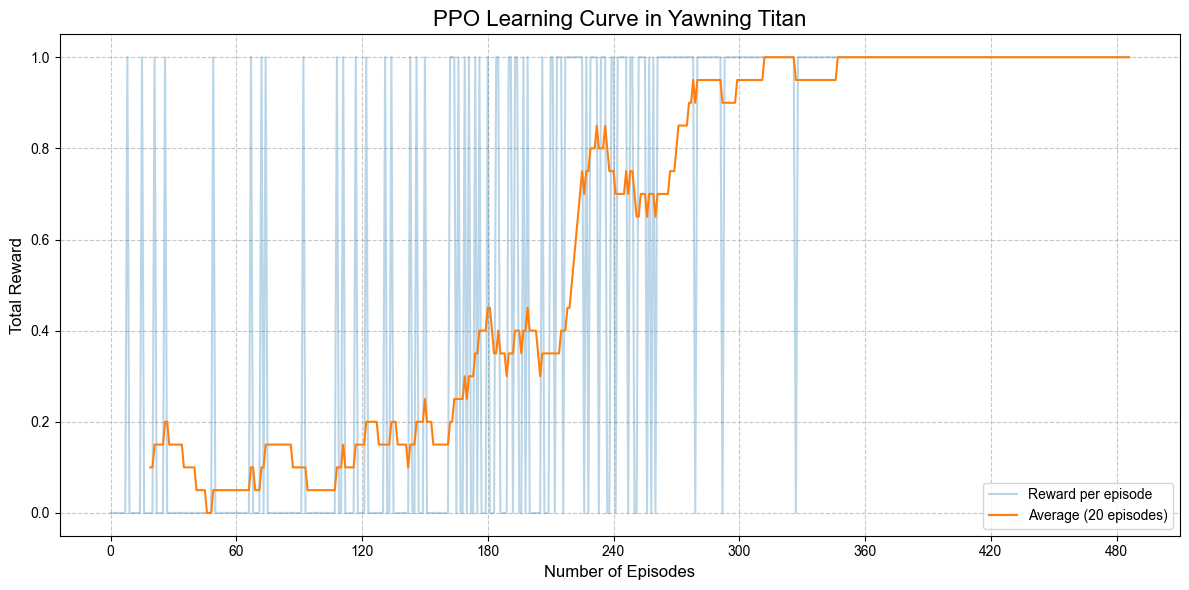

In [16]:
# Calculate the moving average
window_size = 20
moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.3, color='#1f77b4', label='Reward per episode')
plt.plot(range(window_size-1, len(rewards)), moving_avg, color='#ff7f0e', label=f'Average ({window_size} episodes)')
plt.title('PPO Learning Curve in Yawning Titan', fontsize=16)
plt.xlabel('Number of Episodes', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.style.use('seaborn')
plt.tight_layout()
plt.show()